In [22]:
# Collapse of a real, massless scalar field

# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [23]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# import homemade code
sys.path.append('../')
from source.rhsevolution import *                             # go here to look at how the evolution works
from source.scalarcollapseinitialconditions import *              # go here to change the initial conditions
from source.hamdiagnostic import *                            # go here to change the Ham constraint diagnostic
from source.grid import Grid
from source.spacing import *
from source.rhodiagnostic import *
from source.ahfinder import *

In [24]:
params_phi = [0.031,10,1] # amplitude, radius, width

# Input parameters for grid and evolution here
r_max = 96.0 # outer edge of the grid (including ghosts)
min_dr = 1e-2
max_dr = 2

# SinhSpacing
# params = SinhSpacing.get_parameters(r_max, min_dr, max_dr)
# sp = SinhSpacing(**params)

# CubicSpacing
params = CubicSpacing.get_parameters(r_max, min_dr, max_dr)
sp = CubicSpacing(**params)

print(params)
grid = Grid(sp)
r = grid.r
num_points = r.size

{'r_max': 96.0, 'extent': <SpacingExtent.HALF: 0>, 'a': np.float64(0.10106821140712906), 'num_points': 147}


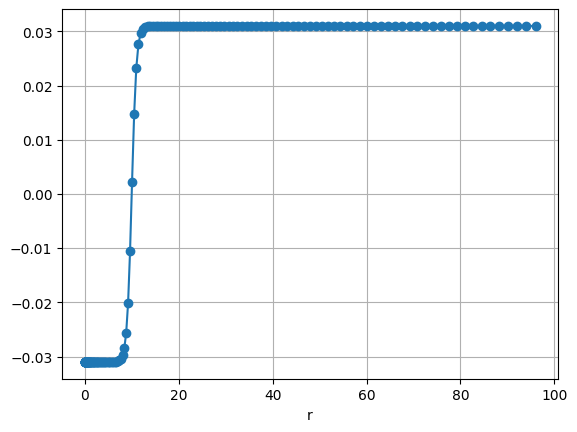

In [25]:
initial_state = get_initial_state(grid, params_phi)


#unpackage the vector for readability
(initial_u, initial_v , initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse) = np.array_split(initial_state, NUM_VARS)

# #plot initial conditions
plt.xlabel('r')
plt.plot(r, initial_u, '-o', label='u') # zero, but plot as dots to see the grid
# plt.plot(r, initial_phi, label='v')
# plt.plot(r, initial_phi, label='phi')
# # plt.plot(r, np.exp(-4.0*initial_phi), label='emphi')
# # plt.plot(r, initial_hrr, label='hrr')
# # plt.plot(r, initial_htt, label='htt')
# # plt.plot(r, initial_lambdar, label='lambdar')
# # plt.plot(r, initial_shiftr, label='shiftr')
# # plt.plot(r, initial_lapse-1, label='lapse - 1')
# plt.legend(loc='best')
plt.grid()
# plt.xlim(-0.25,5.0)
# plt.ylim(-0.0005,0.0005)

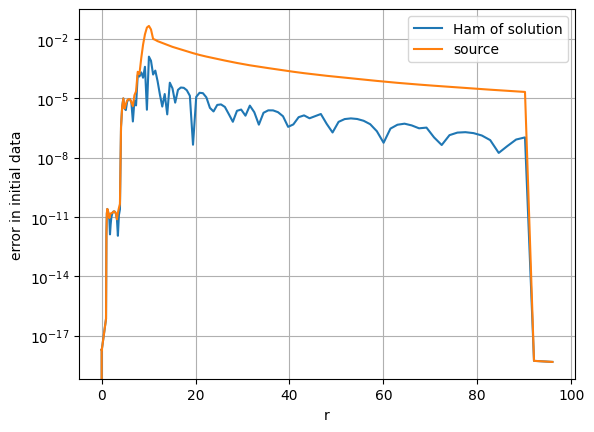

In [26]:
# check the Hamiltonian constraint initially satisfied
# apart from numerical errors
Ham = get_Ham_diagnostic(initial_state, np.array([0]), grid)
absHam = get_absHam_diagnostic(initial_state, np.array([0]), grid)
# rho = get_rho_diagnostic(initial_state, np.array([0]), grid)

# plot the profile for Ham
plt.plot(r, abs(Ham[0]), label=r"Ham of solution")
plt.plot(r, absHam[0], label=r"source")

plt.yscale('log')
plt.xlabel('r')
# plt.xlim(0,20)
# plt.ylim(-100,100)
plt.ylabel('error in initial data')
plt.legend()
plt.grid()

In [27]:
# for control of time integrator and spatial grid
T = 32.0 # Maximum evolution time
num_points_t = 101 # time resolution (only for outputs, not for integration)

# Work out dt and time spacing of outputs
dt = T/num_points_t
t = np.linspace(0, T-dt, num_points_t)
eta = 10.0 # the 1+log slicing damping coefficient - of order 1/M_adm of spacetime

# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead
# use tqdm package to track progress
with tqdm(total=1000, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_state, 
                               args=(grid, eta, progress_bar, [0, T/1000]),
                        #atol=1e-5, rtol=1e-5,
                        max_step=(0.4*min_dr), #for stability and for KO coeff of 10
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points defined in myparams.py
solution = dense_solution.sol(t).T

100%|█████████▉| 999/1000 [01:10<00:00, 14.24‰/s]


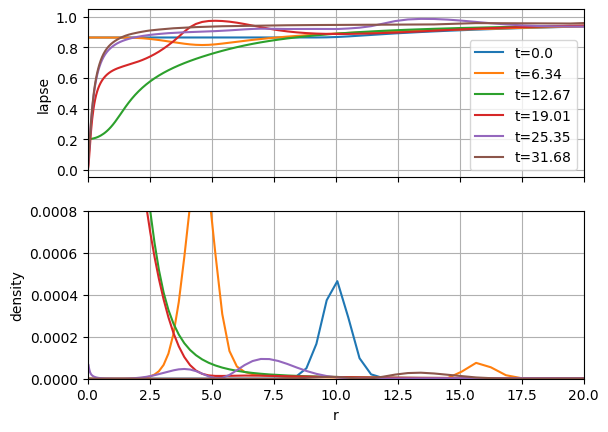

In [28]:
# plot the profile for some variable at a selection of times
var = idx_lapse
rho = get_rho_diagnostic(solution, t, grid)

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for i, t_i in enumerate(t) :
    if (i < num_points_t) and (i % 20 == 0):
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * num_points: (var + 1) * num_points]
        ax1.plot(r, f_t, label=labelt)
        rho_t = rho[i]
        ax2.plot(r, rho_t)

# ax2.plot(r, rho[0])
# print(rho[0][0][:])

ax1.legend(loc=4)
ax2.set_xlabel('r')
ax1.set_xticklabels([])
ax1.set_xlim(0,20)
ax2.set_xlim(0,20)

ax2.set_ylim(-1e-7,8e-4)

# ax2.set_yscale("log")
ax1.set_ylabel('lapse')
ax2.set_ylabel('density')

ax1.grid()
ax2.grid()

0.1398970475176434


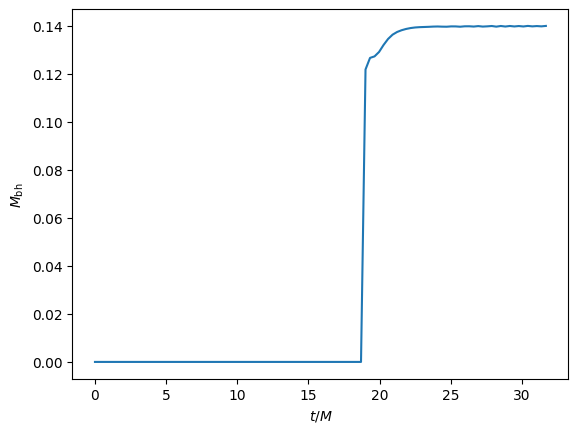

In [32]:
theta, massBH = find_massBH(solution, t, grid)
plt.plot(t,massBH)
plt.ylabel(r"$M_\mathrm{bh}$")
plt.xlabel(r"$t/M$")

print(massBH[-1])

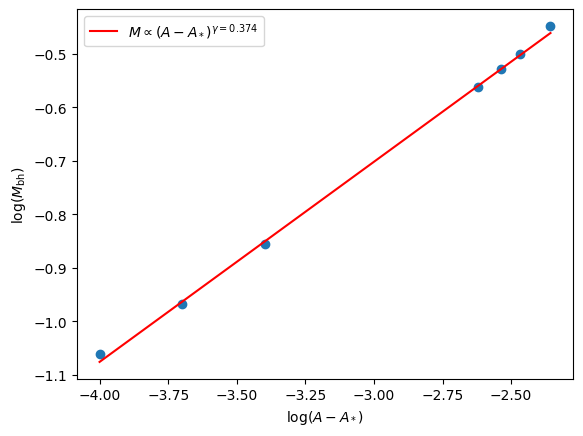

In [10]:
crit = np.array([0.0307, 0.0308, 0.031, 0.033, 0.0335, 0.034, 0.035])
M = [0.08692007718780992, 0.10761034057997663, 0.13935348388461014, 0.274066908105834, 0.2954678260486774, 0.31627135917586724, 0.3563722911849538]

plt.scatter(np.log10(crit-0.0306), np.log10(M))
plt.plot(np.log10(crit-0.0306), 0.374*np.log10(crit-0.0306)+0.42,c="r",label=r"$M\propto (A-A_*)^{\gamma=0.374}$")

plt.xlabel(r"$\log(A-A_*)$")
plt.ylabel(r"$\log(M_\mathrm{bh})$")
plt.legend()

In [33]:
# Animation of the fields (u, v) varying in time
from matplotlib import animation
# plt.rcParams['animation.ffmpeg_path'] = '/Users/aurrekoetxea/Documents/engrenage/env/lib/python3.11/site-packages/ffmpeg'
%matplotlib notebook


# Select variable to plot (u or v)
var_to_plot_id, var_label = idx_lapse, r'$\alpha(t,r)$'
#var_to_anim_id, var_label = idx_v, r'$v(t,r)$'

# Pick it out of the solution vector
var_to_anim = solution[:, var_to_plot_id * num_points:var_to_plot_id * num_points + num_points]

# Set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

# ax1 = plt.axes(xlim=(r[num_ghosts], r[-num_ghosts]), ylim=(-0.,1.1))
line, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2)

ax1.set_xlabel(r'$r$')
ax1.set_ylabel(var_label)

ax1.set_xlim([r[NUM_GHOSTS], r[-NUM_GHOSTS]])
ax1.set_ylim([0, 1.1])
ax2.set_xlim([r[NUM_GHOSTS], r[-NUM_GHOSTS]])
ax2.set_ylim([0, 1e-3])
ax2.set_xlabel(r'$r$')
ax2.set_ylabel(r"$\rho(t,r)$")

def init():
    line.set_data([], [])
    line2.set_data([], [])
    return line, line2,

# Animation function. This is called sequentially
def animate(i):
    x = r[NUM_GHOSTS:-NUM_GHOSTS]
    y1 = var_to_anim[i][NUM_GHOSTS:-NUM_GHOSTS]
    y2 = rho[i][NUM_GHOSTS:-NUM_GHOSTS]
    line.set_data(x, y1)
    line2.set_data(x, y2)

    return line, line2,

# Call the animator
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.arange(0,num_points_t,1), interval=100, blit=True)

# Display the animation interactively.
from IPython.display import HTML
HTML(anim.to_jshtml())


<IPython.core.display.Javascript object>

In [ ]:
anim.save('./field_animation.gif', fps=20)